# 2. Pair Trading Example

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

%matplotlib inline

In [2]:
def compose_xt(s1, s2, A, B):
    alpha = A / s1[0]
    beta = B / s2[0]
    return alpha * s1 - beta * s2

In [3]:
# Same example 
GDX = pd.read_csv('GDX_historical.csv')
GLD = pd.read_csv('GLD_historical.csv')
SLV = pd.read_csv('SLV_historical.csv')

gld = GLD['Adj Close'].to_numpy()
gdx = GDX['Close'].to_numpy()
slv = SLV['Close'].to_numpy()

print('Numbner of data points in file = ', gld.size)

#  The book uses only 200 points, so we'll trim our data down.
#  I wrote this so you can easily adjust which 200 points are used.
#  Obviously, don't go beound the length of the raw data.

M = 3
gld = gld[M:M + 200]
gdx = gdx[M:M + 200]
slv = slv[M:M + 200]

N = gld.size
dt = 1/252

Numbner of data points in file =  210


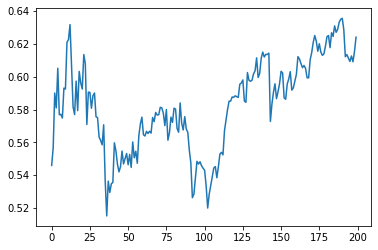

In [4]:
x = compose_xt(gld, gdx, 1, 0.454)
plt.plot(x)

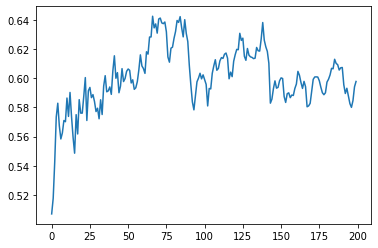

In [5]:
x = compose_xt(gld, slv, 1, 0.493)
plt.plot(x)

In [6]:
# Ornstein-Uhlenbeck process is not just stationary but also normally distributed
# ou parameter : dXt = mu(theta - Xt)dt + sigma * dBt
#      - Bt : standard Brownian motion under the probability measure P
#      - mu : deterministic part & the drift of the process, mean-reversion rate
#      - sigma : control the random process 
#      - θ : long-term mean, θ ∈ R
#      - If sigma is large enough, then mu become unsignificant for the process

In [7]:
# Source of Mathmatical Calculation
# https://www.ubs.com/global/en/investment-bank/in-focus/research-focus/quant-answers/quant-insight-series/_jcr_content/mainpar/toplevelgrid_7262680_322968126/col1/actionbutton_3358030.1305440028.file/PS9jb250ZW50L2RhbS9pbnRlcm5ldGhvc3RpbmcvaW52ZXN0bWVudGJhbmsvZW4vZXF1aXRpZXMvcWlzLXZpcnR1YWwtZXZlbnQtZGVja3MtMjAyMC9tci10cmFkaW5nLXRhbGstdWJzLWFwcmlsLTIwMjEucGRm/mr-trading-talk-ubs-april-2021.pdf
# https://github.com/mghadam/ouparams/blob/main/src/ouparams/ouparams.py
# https://reference.wolfram.com/language/ref/OrnsteinUhlenbeckProcess.html

def get_optimal_ou_params(X, dt): 
    """
    Xx = Σ(i=1, i=n) x(i-1)
    Xy = Σ(i=1, i=n) x(i)
    Xxx = Σ(i=1, i=n) x(i-1)^2
    Xyy = Σ(i=1, i=n) x(i)^2
    Xxy = Σ(i=1, i=n) x(i) * x(i-1)
    """
    n = X.size
    Xx  = np.sum(X[:-1])
    Xy  = np.sum(X[1:])
    Xxx = np.sum(X[:-1]**2)
    Xyy = np.sum(X[1:]**2)
    Xxy = np.sum(X[:-1] * X[1:])
        
    theta_star = ((Xy * Xxx) - (Xx * Xxy))/(n*(Xxx - Xxy) - ((Xx**2) - Xx * Xy)) # Mean
    mu_star = -(1 / dt) * np.log((Xxy - theta_star * Xx - theta_star * Xy + n*theta_star**2)/(Xxx - 2 * theta_star * Xx + n * theta_star**2))    
    alpha = np.exp(-mu_star * dt) # Rate
    sigma_h = np.sqrt((1/n)*(Xyy-(2*alpha*Xxy)+((alpha**2)*Xxx)-(2*theta_star*(1-alpha)*(Xy-alpha*Xx))+(n*(theta_star**2)*(1-alpha)**2)))
    sigma_star = np.sqrt((sigma_h**2)*(2*mu_star/(1-alpha**2)))  # Volatility

    return theta_star, mu_star, sigma_star


"""Inaccurate Result
def fit_ar1(ts: pd.Series, dt:float = 1/252) -> (np.array, float):
    
    # Fit AR(1) process from time series of price
    
    ts_y = ts.values[1:].reshape(-1, 1)
    ts_x = np.append(np.ones(len(ts_y)), ts.values[:-1]).reshape(2,-1).T
    
    phi = np.linalg.inv(ts_x.T @ ts_x) @ ts_x.T @ ts_y
    sigma = np.sqrt(np.sum((ts_y - ts_x @ phi) ** 2) / (len(ts_y)))
    phi = phi.reshape(-1)
    
    theta = phi[0] / (1-phi[1])
    mu = (1-phi[1]) / dt
    sigma = sigma / np.sqrt(dt)
    return theta, mu, sigma
"""


def log_likelihood(theta, mu, sigma, S, dt ):    
    sigma0 = sigma**2 * (1 - np.exp(-2*mu*dt)) / (2 * mu)
    sigma0 = np.sqrt( sigma0 )
    
    N = S.size
    
    term1 = -0.5 * np.log(2 * np.pi)
    term2 = -np.log(sigma0)
    
    prefactor = -1 / (2 * N * sigma0**2)
    sum_term = 0
    for i in range(1, N):
        x2 = S[i]
        x1 = S[i-1]
        
        sum_term = sum_term + (x2 - x1 * np.exp(-mu*dt) - \
                   theta * (1-np.exp(-mu*dt)))**2
    
    f = (term1 + term2 + prefactor * sum_term)
    return f

In [8]:
dt

0.003968253968253968

In [9]:
B_over_A = np.linspace(0.001, 1, 1000)
likelihood_gld_gdx = []

for value in B_over_A:
    alpha = 1 / gld[0]
    
    beta = value / gdx[0]
    
    X = alpha * gld - beta * gdx
    
    parameters = get_optimal_ou_params(X, dt)
    likelihood_gld_gdx.append(log_likelihood(theta, mu, sigma, X, dt=1/252))
    
likelihood_gld_slv = []

for value in B_over_A:
    alpha = 1 / gld[0]
    
    beta = value / slv[0]
    
    X = alpha * gld - beta * slv

    parameters = get_optimal_ou_params(X, dt)
    likelihood_gld_slv.append(log_likelihood(theta, mu, sigma, X, dt=1/252))

NameError: name 'theta' is not defined

In [ ]:
#  We want to plot things in terms of B, but we set A = 1 above so B/A = B.
#  I am just making it explicit here for clarity.
B = B_over_A * 1
plt.plot(B, likelihood_gld_gdx, 'k', label = 'GLD-GDX')
plt.plot(B, likelihood_gld_slv, ':', label = 'GLD-SLV')
plt.xlabel('B')
plt.ylabel('Log Likelihood')
plt.grid()
plt.legend()

In [ ]:
V = np.amax(likelihood_gld_gdx)
ind = np.where(likelihood_gld_gdx == V)
ind = ind[0]
print('GLD-GDX: ', B[ind][0] )

#  Do the same with for the pair with SLV
V = np.amax(likelihood_gld_slv)
ind = np.where(likelihood_gld_slv == V)
ind = ind[0]
print('GLD-SLV: ', B[ind][0] )

In [ ]:
table

# Optimal Stopping Problem

In [ ]:
import numpy as np
from scipy.integrate import quad
from typing import Callable

import matplotlib.pyplot as plt


def function_F(mu: np.float32,
               sigma: np.float32,
               theta: np.float32,
               r: np.float32) -> Callable[np.float32, np.float32]:
    
    def f(u, x):
        term1 = u**(r/mu - 1)
        term2 = np.exp( (np.sqrt(2*mu/(sigma**2))) * (x-theta) * u - (u**2)/2 )
        return term1 * term2
    
    def F(x):
        return quad(f, 0, np.inf, args(x,))[0]
    

def function_F_prime(mu: np.float32,
                     sigma: np.float32,
                     theta: np.float32,
                     r: np.float32) -> Callable[np.float32, np.float32]:
    
    def F_prime(x):
        term1 = u**(r/mu)
        term2 = np.sqrt(2*mu/(sigma**2))
        term3 = np.exp( term2 * (x-theta) * u - (u**2)/2 )
        return term2 * quad(term1 * term3,  0, np.inf, args(x,))[0]
    


def function_G(mu: np.float32,
               sigma: np.float32,
               theta: np.float32,
               r: np.float32) -> Callable[np.float32, np.float32]:
    
    def g(u, x):
        term1 = u**(r/mu - 1)
        term2 = np.exp( (np.sqrt(2*mu/(sigma**2))) * (theta-x) * u - (u**2)/2 )
        return term1 * term2
    
    def G(x):
        return quad(f, 0, np.inf, args(x,))[0]

    
    
def function_G_prime(mu: np.float32,
               sigma: np.float32,
               theta: np.float32,
               r: np.float32) -> Callable[np.float32, np.float32]:
    
    def G_prime(x):
        term1 = u**(r/mu)
        term2 = np.sqrt(2*mu/(sigma**2))
        term3 = np.exp( term2 * (theta-x) * u - (u**2)/2 )
        return term2 * quad(term1 * term3,  0, np.inf, args(x,))[0]
    

In [ ]:
def function_V(b: np.float32,
               c: np.float32,
               F: Callable[np.float32, np.float32]) -> Callable[np.float32, np.float32]:

In [ ]:
import numpy as np
import scipy.integrate
from typing import Callable

import matplotlib.pyplot as plt


#%%
import pandas as pd
import numpy as np
from scipy.integrate import quad

def testcase(length = 100, tp= 'ar1'):
    if tp == 'ar1':
        phi = np.random.uniform(-1,1,1)
        sigma = np.random.uniform(0, 100,1)
        y_0 = np.random.randint(10,1000,1)
        const = np.random.uniform(0, sigma,1)
        
        res = np.random.randn(length) * sigma
        res[0] = y_0
        start = 1
        while start < length:
            res[start] += const + phi * res[start-1]
            start +=1
        return pd.Series(res), np.concatenate([const, phi, sigma])
            
        
def compose_portfolio(X_a: pd.Series,
                      X_b: pd.Series,
                      A: float,
                      B: float) -> pd.Series:

    return A / X_a[0] * X_a + B / X_b[0] * X_b

def compute_likelihood(X, theta, mu, sigma, t_delta) -> np.float32:
    """
    params is consist of theta, mu, sigma 
    For a cerain strategy(α, β), using the portfolio values x (α, β, t=i), with i = 0~n
    """

    sigma_tilda_square = ( sigma ** 2 ) * ( 1- np.exp(-2 * mu * t_delta)) / (2 * mu)
    sigma_tilda = sigma_tilda_square ** (1/2)
    
    # X[1:] means Xi and X[:-1] means Xi-1
    summation = np.sum((X[1:] - (X[:-1] * np.exp(-mu * t_delta)) - theta * (1-np.exp(-mu * t_delta))) ** 2)
    l = -0.5 * np.log(2 * np.pi) - np.log(sigma_tilda) - (summation / (2 * (len(X)) * sigma_tilda_square))
    return l

def find_optimal_portfolio_ratio(X_a: pd.Series,
                                 X_b: pd.Series,
                                 B_range: np.ndarray):
    B_to_ls = []
    for B in B_range:
        X = compose_portfolio(X_a=X_a, X_b=X_b, A=1.000, B=-B)
        theta, mu, sigma = fit_ar1(ts=X)
        l = compute_likelihood(X, theta, mu, sigma, t_delta=1)
        # print(B, X[0], l)
        B_to_ls.append((B, l))

    B_max = max(B_to_ls, key=lambda x: x[1])[0]
    print(B_max)
    return B_max


def fit_ar1(ts: pd.Series, dt:float = 1) -> (np.array, float):
    """
    Fit AR(1) process from time series of price
    """
    ts_y = ts.values[1:].reshape(-1, 1)
    ts_x = np.append(np.ones(len(ts_y)), ts.values[:-1]).reshape(2,-1).T
    
    phi = np.linalg.inv(ts_x.T @ ts_x) @ ts_x.T @ ts_y
    sigma = np.sqrt(np.sum((ts_y - ts_x @ phi) ** 2) / (len(ts_y)))
    phi = phi.reshape(-1)
    
    theta = phi[0] / (1-phi[1])
    mu = (1-phi[1]) / dt
    sigma = sigma / np.sqrt(dt)
    
    return theta, mu, sigma


def derive_ou_params(X: pd.Series,
                     dt: float = 1)  -> (np.float64, np.float64, np.float64):
    """
    Derived parametes for OU process from estimated parameters of AR(1) process
    """
    # X = alpha * asset1 - beta * asset2
    
    N = X.size
    Xx  = np.sum(X[0:-1])
    Xy  = np.sum(X[1:])
    Xxx = np.sum(X[0:-1]**2)
    Xxy = np.sum(X[0:-1] * X[1:])
    Xyy = np.sum(X[1:]**2)

    theta = (Xy * Xxx - Xx * Xxy) /  (N * (Xxx - Xxy) - (Xx**2 - Xx * Xy) ) 
    mu = -(1 / dt) * np.log(Xxy - theta * Xx - theta * Xy + N * theta**2) / (Xxx - 2 * theta * Xx + N * theta**2)

    pref = 2 * mu / (N * (1 - np.exp(-(2 * mu * dt))))
    term = Xyy -  2 * np.exp(-mu * dt) * Xxy + np.exp(-2 * mu * dt) * Xxx \
        - 2 * theta * (1 - np.exp(- mu * dt)) * (Xy - np.exp(-mu * dt) * Xx)\
        + N * theta**2 * (1 - np.exp(- mu * dt))**2

    sigma = np.sqrt(pref * term)
    return theta, mu, sigma


def define_function_F(mu: np.float32,
                      sigma: np.float32,
                      theta: np.float32,
                      r: np.float32) -> Callable[np.float32, np.float32]:

    def f(u, x):
        return u**(r / mu - 1) * np.exp(np.sqrt(2 * mu / sigma**2) * (x - theta) * u - u**2/2)

    def F(x):
        return scipy.integrate.quad(f, 0, np.inf, args=(x,))[0]

    return F

def define_function_F_prime(mu: np.float32,
                            sigma: np.float32,
                            theta: np.float32,
                            r: np.float32) -> Callable[np.float32, np.float32]:

    def f_prime(u, x):
        return u**(r / mu) * np.exp(np.sqrt(2 * mu / sigma**2) * (x - theta) * u - u**2/2) * np.sqrt(2 * mu / sigma**2)
    
    def F_prime(x):
        return scipy.integrate.quad(f_prime, 0, np.inf, args=(x,))[0]
    
    return F_prime


def define_function_G(mu: np.float32,
                      sigma: np.float32,
                      theta: np.float32,
                      r: np.float32) -> Callable[np.float32, np.float32]:

    def g(u, x):
        return u**(r / mu - 1) * np.exp(np.sqrt(2 * mu / sigma**2) * (theta - x) * u - u**2/2)

    def G(x):
        return scipy.integrate.quad(g, 0, np.inf, args=(x,))[0]

    return G



def define_function_G_prime(mu: np.float32,
                            sigma: np.float32,
                            theta: np.float32,
                            r: np.float32) -> Callable[np.float32, np.float32]:

    def g_prime(u, x):
        return u**(r / mu) * np.exp(np.sqrt(2 * mu / sigma**2) * (theta - x) * u - u**2/2) * (-np.sqrt(2 * mu / sigma**2))

    def G_prime(x):
        return scipy.integrate.quad(g_prime, 0, np.inf, args=(x,))[0]

    return G_prime





def define_function_V(b: np.float32,
                      c: np.float32,
                      F: Callable[np.float32, np.float32]) -> Callable[np.float32, np.float32]:
    
    def V(x: np.float32) -> Callable[np.float32, np.float32]:
        if x < b:
            return (b - c) * F(x) / F(b)
        else:
            return x - c

    return V

def define_function_V_prime(b: np.float32,
                            c: np.float32,
                            F: Callable[np.float32, np.float32],
                            F_prime: Callable[np.float32, np.float32]) -> Callable[np.float32, np.float32]:
    
    def V_prime(x): 
        if x < b:
            return (b - c) * F_prime(x) / F(b)
        else:
            return 1

    return V_prime

def define_function_J(d: np.float32,
                      c: np.float32,
                      G: Callable[np.float32, np.float32],
                      V: Callable[np.float32, np.float32]) -> Callable[np.float32, np.float32]:
    
    def J(x: np.float32) -> Callable[np.float32, np.float32]:
        
        if x < d: # 0.546 < d
            return V(x) - x - c
        else: # d < 0.546 
            return (V(d) - d - c) * G(x) / G(d)
    
    return J

def find_b_star(x: np.float32,
                c: np.float32,
                F: Callable[np.float32, np.float32],
                domain: np.array) -> np.float32: 
    
    # Temporary implementation
    i_b_star = np.argmax([define_function_V(b=b, c=c, F=F)(x) for b in domain]) 
    b_star = domain[i_b_star]
    return b_star

    # Original implementation
    
    # def find_b_star(x, cost, F, F_prime, lr = 1/3):
    #     error = np.finfo(float).max
    #     while True:
    #         fb, fpb = F(x), F_prime(x)
    #         if fpb <=0:
    #             raise ValueError("F' is not > 0")
    #         error = (cost - x) * fpb +fb
    #         # print(f'{error} at {fb}, {fpb}, {x}')
    #         if abs(error) > 1e-14:
    #             x += lr * error/fpb
    #         else:
    #             break
    #     return x

def find_d_star(x: np.float32,
                c: np.float32,
                G: Callable[np.float32, np.float32],
                V: Callable[np.float32, np.float32],
                domain: np.array) -> np.float32: 
    
    # Temporary implementation
    i_d_star = np.argmax([define_function_J(d=d, c=c, G=G, V=V)(x) for d in domain]) 
    d_star = domain[i_d_star]
    return d_star

    # Original implementation

    # def find_d_star(x, cost, G, G_prime, V, V_prime, lr =1/100):
    #     error = np.finfo(float).max
    #     while True:
    #         g_temp, v_temp = G(x), V(x, cost) - x -cost
    #         gp, vp = G_prime(x), V_prime(x, cost) -1
    #         # if v_temp <=0:
    #         #     raise ValueError("V-b-c is not > 0")
    #         try:
    #             # error = gp/g_temp - vp/v_temp
    #             error = v_temp - g_temp
    #         except ZeroDivisionError:
    #             print(f'{x} with {error} = {v_temp} - {g_temp} and {gp}, {vp}')
    #         # print(f'{error} at {v_temp} - {g_temp}')
    #         if abs(error) > 1e-14:
    #             if vp > gp:
    #                 x += lr * error/vp
    #             else:
    #                 x -= lr * error/gp
    #         else:
    #             break
    #     return x

#%%
if __name__ == "__main__":
    '''
    df = load_table(table_name, item_code, date_range, config)
    alpha, beta, se = fit_ar1(df[PRICE])
    mu, theta, sigma = derive_ou_params(alpha, beta, se)
    '''
    
    ## Testing AR1
    data, param = testcase(length = 100, tp= 'ar1')
    params = fit_ar1(data)
    params2 =derive_ou_params(data)
    res = pd.DataFrame([params, params2], columns = ['theta','mu','sigma']).T
    res.columns = ['AR1', 'Analytical']
    print(res)

    mu, sigma, theta, r = 0.2, 27, 61, 0.1

    f = F(mu, sigma, theta, r)
    f2 = F_prime(mu, sigma, theta, r)
    b = b_star(70, 5, f, f2)

    #%%
    v = V(b, f)
    v2 = V_prime(b, f, f2)
    g = G(mu, sigma, theta, r)
    g2 = G_prime(mu, sigma, theta, r)
    d = d_star(10, 5, g, g2, v, v2)

In [ ]:
a = define_function_F(mu, sigma, theta, r)

In [ ]:
a